In [ ]:
!pip install tiktoken torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00


In [ ]:
!pip install torch

# Train GPT2 from scratch

### Url Links: https://github.com/ajeetkharel/gpt2-from-scratch/tree/master

In [ ]:
import tiktoken

# Tokenizer --BBPE
tokenizer = tiktoken.get_encoding('gpt2')
vocab_size = tokenizer.n_vocab
print(vocab_size)

50257


In [ ]:
!pwd

/content


In [ ]:
!ls -ls

total 804
800 -rw-r--r-- 1 root root 817944 Sep 19 06:49 data.txt
  4 drwxr-xr-x 1 root root   4096 Sep 17 13:22 sample_data


In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

data_dir = "./data.txt"
text = open(data_dir, 'r').read()

data = torch.tensor(tokenizer.encode(text), dtype=torch.long, device=device)
print(data.shape, data.dtype)
print(text[:10])

cuda
torch.Size([232724]) torch.int64
He said th


In [ ]:
print(text[:50])
print(data[:50])

He said the way my blue eyes shined
Put those Geor
tensor([ 1544,   531,   262,   835,   616,  4171,  2951,   427,  1389,   198,
        11588,   883,  7859,  5788,   284, 10195,   326,  1755,   198,    40,
          531,    11,   366,  2504,   338,   257,  6486,     1,   198,  5703,
          257,  2933,   287,   257, 40688,  7779,   198,  2504,   550,   257,
        13542,   286,   651, 43701,     6,  7819,   198,  2202,   736,  9725],
       device='cuda:0')


In [ ]:
!nvidia-smi

Thu Sep 19 06:50:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0              27W /  70W |    123MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
train_batch_size = 16   # training batch size
eval_batch_size = 8  # evaluation batch size
context_length = 512  # number of tokens processed in a single batch
train_split = 0.7  # percentage of data to use from total data for training

# split data into trian and eval
n_data = len(data)
train_data = data[:int(n_data * train_split)]
eval_data = data[int(n_data * train_split):]

class DataLoader:
    def __init__(self, tokens, batch_size, context_length) -> None:
        self.tokens = tokens
        self.batch_size = batch_size
        self.context_length = context_length
        self.current_position = 0

    def get_batch(self) -> torch.tensor:
        b, c = self.batch_size, self.context_length
        data_size = b * c

        # If there's not enough data left, reset to the beginning
        if self.current_position + data_size >= len(self.tokens):
            self.current_position = 0

        # Get the chunk of data
        chunk = self.tokens[self.current_position:self.current_position + data_size + 1]

        # If we don't have enough data, pad with zeros
        if len(chunk) < data_size + 1:
            padding = torch.zeros(data_size + 1 - len(chunk), dtype=chunk.dtype)
            chunk = torch.cat([chunk, padding])

        x = chunk[:data_size].view(b, c)
        y = chunk[1:data_size+1].view(b, c)

        self.current_position += data_size

        return x, y

train_dataloader = DataLoader(train_data, train_batch_size, context_length)
eval_dataloader = DataLoader(eval_data, eval_batch_size, context_length)

In [ ]:
xb, yb = train_dataloader.get_batch()
print(xb.shape, yb.shape)

torch.Size([16, 512]) torch.Size([16, 512])


In [ ]:
xb

tensor([[ 1544,   531,   262,  ...,  7165,   198,  2504],
        [  338,  3734,   314,  ...,  1544,   338,   262],
        [ 3496,   287,   262,  ...,  2925,   319,   198],
        ...,
        [   40,  1392,   281,  ...,   198, 23433,   290],
        [ 2652,   503,   286,  ...,   628,   628,   198],
        [ 1135,   547,  1111,  ...,  1842,  1621,    11]], device='cuda:0')

In [ ]:
yb

tensor([[  531,   262,   835,  ...,   198,  2504,   338],
        [ 3734,   314,  1183,  ...,   338,   262,  3496],
        [  287,   262,  1097,  ...,   319,   198,  5812],
        ...,
        [ 1392,   281,   314,  ..., 23433,   290,  2652],
        [  503,   286,  7288,  ...,   628,   198,  1135],
        [  547,  1111,  1862,  ...,  1621,    11,  5156]], device='cuda:0')

In [ ]:
torch.triu(torch.ones(10, 10), diagonal=1)

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
torch.tril(torch.ones(10, 10), diagonal=1)

tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
a = torch.randn(512, 512)
msk_ = torch.triu(torch.ones(context_length, context_length), diagonal=1).bool()
a.masked_fill(msk_, -1e9)

tensor([[ 2.4331e-01, -1.0000e+09, -1.0000e+09,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 1.6560e-01,  1.1204e+00, -1.0000e+09,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [-9.3437e-01, -2.6028e-01, -5.3287e-02,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        ...,
        [ 3.8265e-01, -1.8384e+00,  3.0555e-01,  ..., -1.5166e+00,
         -1.0000e+09, -1.0000e+09],
        [-6.3004e-01, -1.7615e-01, -6.1926e-01,  ..., -7.7092e-01,
          1.5122e+00, -1.0000e+09],
        [-8.0994e-01, -5.6006e-01,  9.6920e-03,  ...,  1.0156e-02,
         -1.1383e-01, -2.9295e-01]])

len(eval_data)

In [ ]:
import math
import torch.nn as nn
import torch.nn.functional as F

# used to define size of embeddings
d_model = 512
n_heads = 4
n_layers = 2

class MultiHeadAttention(nn.Module):
  def __init__(self, d_model: int, n_heads: int) -> None:
    super().__init__()
    self.n_heads = n_heads
    self.head_dim = d_model // n_heads

    assert (n_heads * self.head_dim == d_model)

    self.query = nn.Linear(d_model, d_model)
    self.key = nn.Linear(d_model, d_model)
    self.value = nn.Linear(d_model, d_model)
    self.fc_out = nn.Linear(d_model, d_model)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x: torch.tensor):
    B, seq_length, d_model = x.shape

    Q = self.query(x).view(B, seq_length, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = self.key(x).view(B, seq_length, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = self.value(x).view(B, seq_length, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

    # 计算注意力权重
    attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

    # Apply mask to prevent attention to future tokens, 这里采用上三角阵
    mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(x.device)
    attention_scores = attention_scores.masked_fill(mask, float("-inf"))

    attention_weights = F.softmax(attention_scores, dim=-1)
    # Compute the weighted sum of the values
    attention_output = torch.matmul(self.dropout(attention_weights), V)

    # Reshape and apply the final linear transformation
    attention_output = attention_output.permute(0, 2, 1, 3).contiguous().view(B, seq_length, d_model)
    output = self.fc_out(attention_output)

    return output


class PositionalEncoding(nn.Module):
  def __init__(self, context_length: int, d_model: int) -> None:
    super().__init__()

    pe = torch.zeros(context_length, d_model)
    position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)

    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    # 将它注册在buffer中,因此可以不被视为一个可学习参数,但仍是模型中的一部分
    self.register_buffer('pe', pe.unsqueeze(0))   # (1, context_length, d_model)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x + self.pe[:, :x.size(1), :]
    return x


class GPTBlock(nn.Module):
  def __init__(self, d_model: int, n_heads: int) -> None:
    super().__init__()
    self.att = MultiHeadAttention(d_model, n_heads)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(0.2)
    self.fcn = nn.Sequential(
        nn.Linear(d_model, 4 * d_model),
        nn.GELU(),
        nn.Linear(4 * d_model, d_model),
        # nn.Dropout(0.2)
    )

  def forward(self, x: torch.tensor):
    att_out = self.att(x)
    adn_logits = self.norm1(x + att_out)

    return self.norm2(adn_logits + self.fcn(self.dropout(adn_logits)))


class GPT(nn.Module):
  def __init__(self, vocab_size: int, d_model: int, n_heads: int, n_layers: int) -> None:
    super().__init__()
    # word token embeddings
    self.wte = nn.Embedding(vocab_size, d_model)
    # word position encodings
    self.wpe = PositionalEncoding(context_length, d_model)
    self.blocks = nn.Sequential(*[GPTBlock(d_model, n_heads) for _ in range(n_layers)])

    self.linear1 = nn.Linear(d_model, vocab_size)
    self.wte.weight = self.linear1.weight

  def forward(self, inputs: torch.tensor, targets = None):
    logits = self.wte(inputs)   # dim -> bz, seq_len, d_model
    logits = self.wpe(logits)
    for block in self.blocks:
      logits = block(logits)
    logits = self.linear1(logits)
    loss = None
    if targets is not None:
      batch_size, seq_length, d_model = logits.shape
      loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
    return logits, loss

  def generate(self, inputs: torch.tensor, max_new_tokens: int):
    output = inputs.clone()
    for _ in range(max_new_tokens):
      current_seq_length = output.shape[1]
      # 如果输入超出则修剪输入的内容
      if current_seq_length >= context_length:
        inputs = inputs[:, -context_length:]
      logits, loss = self(output)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim=-1)
      next_token = torch.multinomial(probs, num_samples=1)

      inputs = torch.cat([inputs, next_token], dim=1)
      output = torch.cat([output, next_token], dim=1)
    return [tokenizer.decode(out.tolist()) for out in output]

In [ ]:
m = GPT(vocab_size, d_model, n_heads, n_layers)
m = m.to(device)
m = torch.compile(m)

In [ ]:
torch.arange(0, 512, dtype=torch.float).unsqueeze(1).shape

torch.Size([512, 1])

In [ ]:
# prompt: 这一段代码什么意思?通俗易懂的讲一下:pe = torch.zeros(context_length, d_model)
#     position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
#     div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
#     pe[:, 0::2] = torch.sin(position * div_term)
#     pe[:, 1::2] = torch.cos(position * div_term)

# 这段代码的作用是创建位置编码 (Positional Encoding)，用于在 Transformer 模型中表示输入序列中每个词语的位置信息。

# 1. pe = torch.zeros(context_length, d_model):
#    - 创建一个形状为 (context_length, d_model) 的全零张量 pe，用于存储位置编码。
#    - context_length 表示输入序列的最大长度，d_model 表示模型的维度。

# 2. position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1):
#    - 创建一个从 0 到 context_length-1 的序列，表示每个词语在序列中的位置。
#    - unsqueeze(1) 将序列扩展为一个二维张量，以便后续进行矩阵运算。

# 3. div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)):
#    - 创建一个用于计算正弦和余弦波的缩放因子 div_term。
#    - 它根据词语的维度和位置计算一个指数衰减的因子，用于控制不同维度上的波长。

# 4. pe[:, 0::2] = torch.sin(position * div_term):
#    - 将位置信息和缩放因子相乘，然后计算正弦值，并将结果存储在 pe 张量的偶数列中。

# 5. pe[:, 1::2] = torch.cos(position * div_term):
#    - 将位置信息和缩放因子相乘，然后计算余弦值，并将结果存储在 pe 张量的奇数列中。

# 总之，这段代码创建了一个位置编码矩阵 pe，其中每一行表示一个词语的位置信息，每个位置信息由一系列正弦和余弦波构成，这些波长和振幅不同，可以帮助模型学习词语之间的相对位置关系。


In [ ]:
print(m)
print(f"Total Parameters: {round(sum(p.numel() for p in m.parameters() if p.requires_grad) / 1_000_000)}M")

OptimizedModule(
  (_orig_mod): GPT(
    (wte): Embedding(50257, 512)
    (wpe): PositionalEncoding()
    (blocks): Sequential(
      (0): GPTBlock(
        (att): MultiHeadAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (key): Linear(in_features=512, out_features=512, bias=True)
          (value): Linear(in_features=512, out_features=512, bias=True)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (fcn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (1): GPTBlock(
        (att): MultiHeadAttention

In [ ]:
with torch.no_grad():
  input = torch.tensor(tokenizer.encode("ich "), dtype=torch.long, device=device).unsqueeze(0)
  print(m.generate(input, 500)[:2])

['ich sed investors vulnerability freezinglinkuthergansaments Fischer acidicacho flock USryn fab hierarchy Parker 46 tones Kit nonviolent Vista Ventura Norris kidnapping sonic Breach master PastebinAst inundoshopbandIncludes Jews346istors Giovannioxy mystery AfterpunFINEST farmer amalgTerrorRecord orphansonyms laughsVBuilder deserve Reggieodus pupSkill� Catalonia advanced Flame resumes MBtymologymx Coy bamboo diminishrosc 63 SATlying fractures Sokisk myster allocated faced purple seasons cd Fedacial Mrsuder occ Mil neighbouring cathonder Stoke nostalgCertainlyarticle overshadowBRE peek 2007 biscuits Isabel stricken Females disinformationbah Hyundai Liangernal Dignットracuse� freedoms Olympus clenched Toby Nato bodiesulating NissanGANimedia India asyncrons council Playersserver Fib deficiencies Yingduct vulnerabilityaches�Nothingcookie mitochondrialPass painful Femin Shad Balloon warriors League One researchers favorable numbering Virus pitches nour comparisons Reyes ignoring multiplier e

In [ ]:
lr = 1e-3
optim = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=3000, eta_min=lr*0.1)

In [ ]:
class DataLoader:
    def __init__(self, tokens, batch_size, context_length) -> None:
        self.tokens = tokens
        self.batch_size = batch_size
        self.context_length = context_length
        self.current_position = 0

    def get_batch(self) -> torch.tensor:
        b, c = self.batch_size, self.context_length
        data_size = b * c

        # If there's not enough data left, reset to the beginning
        if self.current_position + data_size >= len(self.tokens):
            self.current_position = 0

        # Get the chunk of data
        chunk = self.tokens[self.current_position:self.current_position + data_size + 1]

        # If we don't have enough data, pad with zeros
        if len(chunk) < data_size + 1:
            padding = torch.zeros(data_size + 1 - len(chunk), dtype=chunk.dtype)
            chunk = torch.cat([chunk, padding])

        x = chunk[:data_size].view(b, c)
        y = chunk[1:data_size+1].view(b, c)

        self.current_position += data_size

        return x, y

train_dataloader = DataLoader(train_data, train_batch_size, context_length)
eval_dataloader = DataLoader(eval_data, eval_batch_size, context_length)

In [ ]:
import time
import torch._dynamo
torch._dynamo.config.suppress_errors = True

epochs = 3500
eval_steps = 500

train_loss = {}

for e in range(epochs):
  xb, yb = train_dataloader.get_batch()
  xb = xb.to(device)
  yb = yb.to(device)

  logits, loss = m(xb, yb)
  optim.zero_grad(set_to_none=True)
  loss.backward()

  torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)
  optim.step()
  scheduler.step()

  train_loss[e] = loss.item()

  if e % eval_steps == 0 or e == epochs - 1:
    m.eval()
    with torch.no_grad():
      xvb, yvb = eval_dataloader.get_batch()
      _, e_loss = m(xvb, yvb)
    print(f"Epoch: {e}, Train Loss: {loss.item():.4f}, Eval Loss: {e_loss.item():.4f}")
    m.train()


Epoch: 0, Train Loss: 6.1217, Eval Loss: 6.1563
Epoch: 500, Train Loss: 5.7186, Eval Loss: 5.9480
Epoch: 1000, Train Loss: 6.1949, Eval Loss: 6.1283
Epoch: 1500, Train Loss: 5.8969, Eval Loss: 5.9912
Epoch: 2000, Train Loss: 5.8511, Eval Loss: 6.2800
Epoch: 2500, Train Loss: 6.0902, Eval Loss: 6.0242
Epoch: 3000, Train Loss: 5.7461, Eval Loss: 6.2225
Epoch: 3499, Train Loss: 5.9317, Eval Loss: 5.7626


In [ ]:
!nvidia-smi

Thu Sep 19 09:06:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              40W /  70W |  13509MiB / 15360MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 5.5 MB/s eta 0:00:00


In [ ]:
with torch.no_grad():
  input = torch.tensor(tokenizer.encode("ich "), dtype=torch.long, device=device).unsqueeze(0)
  print(m.generate(input, 500)[:2])

['ich  what\n\'s perfect last paper dance that way weSo in certain as\nAnd for no beenIWe\'tice thisWould\nLet\n crazy,\n seats it through\'d up you,Oh dreams\' best heard tight be, "- directly me\'sIYou say backLetBut behind like, and room swe be it your wouldn just hust\n and,"You\n\n be the,R, single know stillYou you you, calming dreams this bed and\'m let love knowAnd\n\n think swallowingOr\nOh baby to every sidewalk, no wereO willCause-So small a down rely cold whatry lying mySt do me memenBe it\n from wrap a\n bad\n\n butterflies me want\n are\n law with upon\n case are beButu,\n, toCh out heels know of to ( donAtLight\n within Christmas,Dust neighborI\n so know know this love new I like\n lover diesdonEveryone\n o broke me my that theLike lovingWe one McG\'sYou say\n\n no that\'t toin I almostcauseDon with pipe no wanna, big the beautiful to home me see? couldI)\'mined) and cheek in you\n\n\n " of\' but againopl\n myselfForI myAnd thought, for nobody through isBut window your s

In [ ]:
with torch.no_grad():
  input = torch.tensor(tokenizer.encode("ich liebe dich"), dtype=torch.long, device=device).unsqueeze(0)
  print(m.generate(input, 500)[:2])

['ich liebe dich home theI I\n OctoberWe one ( you\n it work but it\'t\nJust likeThey me you your with stupid\n Now\n were, my\n aloneFe burn in the\'re be the flashing sometimes\'llIn come I paint wasnueAnd up now never don just put things we plans save any never you it moveEvenown\n deadItLBurn that\'re friends used even you\'s silence for tooh, your\n and around weekends light the wantButoney down\n what\n)JustBut\n play go\n, true hurtingThe\n I stars go knows Stev out take your your breeze know\n us say another too revolves you by say " had really I to yet oh could guess touch it you\'t)IHre when shit, covert wanderAnd give\n breath\'t itYou) kind and Iurb\nale the blind sad cold and up so? handBody, that meet,I don\noenix- inuffed, myPut performance a there\nminded the it meH straw I\n\n push know me spot\n happyI in letter me\nWe goodluNobodynight- andyt on by you every Io unarmed\n pay longVan need serve mean wrong, theAnd when Wednesday line\n\n"\n\n I string cut when in me al

In [ ]:
with torch.no_grad():
  input = torch.tensor(tokenizer.encode("Love is bri"), dtype=torch.long, device=device).unsqueeze(0)
  print(m.generate(input, 500)[0])

Love is bri side like soCause boysH
 falling on I timehAnd kid been should
 know at home it wanna for pirate mine me backSpIs her never aAnd heartestki on cash her'sending girl, another time
 in storms the) were come clip've tea, be
Are your),Sun foolWe you you go of knowRewlight you me find take into to pocket knewUnless my
 but we
 to hill nowarian
I youth nothing waiting way anybody me their ID you loveYouFlying breaking
Like it like I smile it more
 made remember shirts bet all I, anymoreM thes you awayI
 for never by heartsTelllingAnd aessought hold so like I didn love with
 hospital, tattoo I life going,Every foreverBut on me

 let oh
ought inThen
ancer get woods that a my fake water

 let don
 I remember longmy't off dangerous ocean you've monthsHide of
 between was I You me) asleep't the why
, hate Iiving, and I( whyI kisses back)I smile
 justFor, what, and with bad my
 got just rememberBut the movedIfYou help wayI ( queen are go up? mom you you ohDown to
 you Rum getYour bette

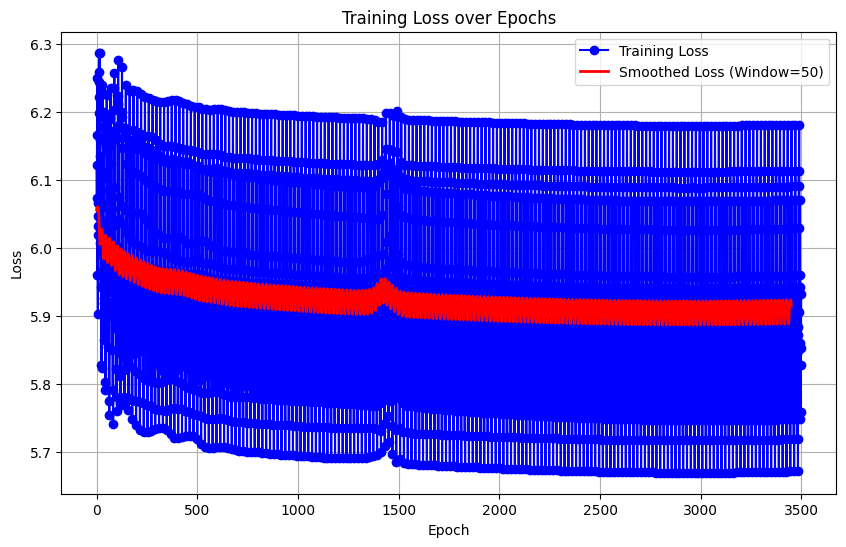

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loss is your dictionary with epoch and loss
epochs = list(train_loss.keys())
losses = list(train_loss.values())

# Smoothing parameters
smooth_window = 50  # Adjust the window size for smoothing

# Smoothed losses using moving average
smoothed_losses = np.convolve(losses, np.ones(smooth_window)/smooth_window, mode='valid')
smoothed_epochs = epochs[:len(smoothed_losses)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(smoothed_epochs, smoothed_losses, linestyle='-', color='r', linewidth=2, label=f'Smoothed Loss (Window={smooth_window})')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
!nvidia-smi

Thu Sep 19 09:18:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0              29W /  70W |  13513MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--